# Pharmaceutical Manufacturing Forecasting and Classification Models

This notebook implements both forecasting and classification models for pharmaceutical manufacturing process optimization based on the available datasets:

## Datasets Overview:
- **Laboratory.csv**: Quality control and laboratory analysis data (1005 batches)
- **Process.csv**: Aggregated process parameters and features 
- **Normalization.csv**: Normalization factors for different product codes
- **Process/1.csv-25.csv**: Time series process data files

## Objectives:
1. **Forecasting Models**: Predict production outcomes, waste, and process parameters
2. **Classification Models**: Classify product quality and detect defects

## Approach:
- LSTM models for time series forecasting
- XGBoost/Gradient Boosting for classification tasks
- Feature engineering from process time series data
- Cross-validation and model evaluation


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import pickle

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)



2025-07-03 16:32:21.339477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751560341.605511      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751560341.685140      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Fixed Data Parsing Issues

**This notebook has been updated to resolve two critical data parsing errors:**

1. **Laboratory Date Parsing**: Fixed `OutOfBoundsDatetime` error when parsing dates like "nov.18", "dec.18" 
   - Added `parse_date_safely()` function that handles month abbreviations and 2-digit years
   - Maps month names (nov→11, dec→12) and converts 2-digit years (18→2018, 19→2019)

2. **Time Series Timestamp Parsing**: Fixed `ValueError` when parsing timestamps like "07052019 20:14"
   - Added `parse_timestamp_safely()` function for DDMMYYYY HH:MM format
   - Includes robust error handling to skip problematic files
   - Filters out rows with failed timestamp parsing

**Result**: The notebook now loads time series data successfully and handles all date/timestamp parsing issues gracefully.


## 1. Data Loading and Exploration


In [2]:
# Load the main datasets

# Load Process data (engineered features from time series)
df_process = pd.read_csv('/kaggle/input/dataset-for-capstone/Data/Process.csv', sep=';')
print(f"Process dataset shape: {df_process.shape}")

# Load Laboratory data (quality control and analysis)
df_laboratory = pd.read_csv('/kaggle/input/dataset-for-capstone/Data/Laboratory.csv', sep=';')
print(f"Laboratory dataset shape: {df_laboratory.shape}")

# Load Normalization factors
df_normalization = pd.read_csv('/kaggle/input/dataset-for-capstone/Data/Normalization.csv', sep=';')
print(f"Normalization dataset shape: {df_normalization.shape}")

print(f"Total batches in process data: {df_process['batch'].nunique()}")
print(f"Total batches in laboratory data: {df_laboratory['batch'].nunique()}")


Process dataset shape: (1005, 35)
Laboratory dataset shape: (1005, 55)
Normalization dataset shape: (25, 3)
Total batches in process data: 1005
Total batches in laboratory data: 1005


In [3]:
# Examine the datasets structure
print("=== PROCESS DATASET ===")
print(f"Columns: {df_process.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_process.head())

print(f"\nData types:")
print(df_process.dtypes)


=== PROCESS DATASET ===
Columns: ['batch', 'code', 'tbl_speed_mean', 'tbl_speed_change', 'tbl_speed_0_duration', 'total_waste', 'startup_waste', 'weekend', 'fom_mean', 'fom_change', 'SREL_startup_mean', 'SREL_production_mean', 'SREL_production_max', 'main_CompForce mean', 'main_CompForce_sd', 'main_CompForce_median', 'pre_CompForce_mean', 'tbl_fill_mean', 'tbl_fill_sd', 'cyl_height_mean', 'stiffness_mean', 'stiffness_max', 'stiffness_min', 'ejection_mean', 'ejection_max', 'ejection_min', 'Startup_tbl_fill_maxDifference', 'Startup_main_CompForce_mean', 'Startup_tbl_fill_mean', 'Drug release average (%)', 'Drug release min (%)', 'Residual solvent', 'Total impurities', 'Impurity O', 'Impurity L']

First few rows:
   batch  code  tbl_speed_mean  tbl_speed_change  tbl_speed_0_duration  \
0      1    25       99.864656          5.416667            149.583333   
1      2    25       99.936342          2.500000            128.333333   
2      3    25       99.985984          2.500000          

In [4]:
# Examine laboratory dataset
print("=== LABORATORY DATASET ===")
print(f"Columns: {df_laboratory.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_laboratory.head())

print(f"\nBasic statistics:")
print(df_laboratory.describe())


=== LABORATORY DATASET ===
Columns: ['batch', 'code', 'strength', 'size', 'start', 'api_code', 'api_batch', 'smcc_batch', 'lactose_batch', 'starch_batch', 'api_water', 'api_total_impurities', 'api_l_impurity', 'api_content', 'api_ps01', 'api_ps05', 'api_ps09', 'lactose_water', 'lactose_sieve0045', 'lactose_sieve015', 'lactose_sieve025', 'smcc_water', 'smcc_td', 'smcc_bd', 'smcc_ps01', 'smcc_ps05', 'smcc_ps09', 'starch_ph', 'starch_water', 'tbl_min_thickness', 'tbl_max_thickness', 'fct_min_thickness', 'fct_max_thickness', 'tbl_min_weight', 'tbl_max_weight', 'tbl_rsd_weight', 'fct_rsd_weight', 'tbl_min_hardness', 'tbl_max_hardness', 'tbl_av_hardness', 'fct_min_hardness', 'fct_max_hardness', 'fct_av_hardness', 'tbl_max_diameter', 'fct_max_diameter', 'tbl_tensile', 'fct_tensile', 'tbl_yield', 'batch_yield', 'dissolution_av', 'dissolution_min', 'resodual_solvent', 'impurities_total', 'impurity_o', 'impurity_l']

First few rows:
   batch  code strength    size   start  api_code  api_batch  s

## 2. Data Preprocessing and Feature Engineering


In [9]:
# FIXED: Create time_series_df from batch_time_series for analysis
# This resolves the NameError: name 'time_series_df' is not defined

if batch_time_series and len(batch_time_series) > 0:
    print("Creating combined time_series_df from batch_time_series...")
    
    # Combine all batch data into a single DataFrame
    all_batch_data = []
    for batch_id, batch_info in batch_time_series.items():
        batch_data = batch_info['data'].copy()
        batch_data['file_id'] = batch_info['file_id']
        all_batch_data.append(batch_data)
    
    # Combine all batches into one DataFrame
    time_series_df = pd.concat(all_batch_data, ignore_index=True)
    
    print(f"Combined time_series_df created with {len(time_series_df):,} total records")
    print(f"Shape: {time_series_df.shape}")
    print(f"Date range: {time_series_df['timestamp'].min()} to {time_series_df['timestamp'].max()}")
else:
    time_series_df = None
    print("No batch_time_series data available, time_series_df set to None")


Creating combined time_series_df from batch_time_series...
Combined time_series_df created with 4,720,208 total records
Shape: (4720208, 18)
Date range: 2018-05-12 00:22:52 to 2021-12-03 17:29:00


In [10]:
# Merge datasets on batch number for comprehensive analysis

# Check for common batches
common_batches = set(df_process['batch']).intersection(set(df_laboratory['batch']))
print(f"Common batches between process and laboratory data: {len(common_batches)}")

# Merge the datasets
df_merged = pd.merge(df_process, df_laboratory, on=['batch', 'code'], how='inner')
print(f"Merged dataset shape: {df_merged.shape}")

# Add normalization factors
df_normalization.columns = ['code', 'batch_size_tablets', 'normalization_factor']
df_merged = pd.merge(df_merged, df_normalization, on='code', how='left')

print(f"Final merged dataset shape: {df_merged.shape}")
print(f"Missing values in merged dataset:")
print(df_merged.isnull().sum().sum())


Common batches between process and laboratory data: 1005
Merged dataset shape: (1005, 88)
Final merged dataset shape: (1005, 90)
Missing values in merged dataset:
144


## 2.5. Loading Actual Time Series Data

The current approach uses aggregated features from Process.csv, but we also have actual time series data in the Process/ directory. Let's load and use this for proper time series forecasting.

**Note**: We handle two data parsing issues:
1. **Date formats**: Laboratory.csv contains dates like "nov.18", "dec.18" that need custom parsing
2. **Timestamp formats**: Process files contain timestamps like "07052019 20:14" (DDMMYYYY HH:MM) that require special handling

The loading functions below include robust error handling to skip problematic files and parse dates/timestamps safely.


In [7]:
# CORRECTED: Efficient time series loading and comprehensive data parsing
import os
import glob
from datetime import datetime
from typing import Dict, List, Tuple, Optional

def parse_date_safely(date_str):
    """CORRECTED: Safely parse dates with complete month mappings"""
    if pd.isna(date_str) or date_str == '':
        return pd.NaT
    
    # Convert to string if not already
    date_str = str(date_str).strip().lower()
    
    # FIXED: Complete month mapping including missing ones
    month_mapping = {
        'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04',
        'may': '05', 'maj': '05',  # FIXED: Added 'maj' for May
        'jun': '06', 'jul': '07', 'aug': '08', 'avg': '08',  # FIXED: Added 'avg' for August
        'sep': '09', 'oct': '10', 'okt': '10',  # FIXED: Added 'okt' for October
        'nov': '11', 'dec': '12'
    }
    
    try:
        if '.' in date_str:
            parts = date_str.split('.')
            if len(parts) == 2:
                month_str, year_str = parts
                if month_str in month_mapping:
                    month = month_mapping[month_str]
                    # Handle 2-digit years (18 -> 2018, 19 -> 2019, 20 -> 2020, 21 -> 2021)
                    if len(year_str) == 2:
                        year_int = int(year_str)
                        if year_int >= 18:  # 18-99 means 2018-2099
                            year = f"20{year_str}"
                        else:  # 00-17 means 2000-2017
                            year = f"20{year_str}"
                    else:
                        year = year_str
                    
                    # Use first day of month for consistency
                    date_formatted = f"{year}-{month}-01"
                    return pd.to_datetime(date_formatted)
        
        # Try standard datetime parsing
        return pd.to_datetime(date_str)
    
    except Exception as e:
        print(f"Warning: Could not parse date '{date_str}': {e}")
        # Return a default date for problematic entries
        return pd.to_datetime('2018-01-01')

def parse_timestamp_safely(timestamp_str):
    """Safely parse timestamps with various formats"""
    if pd.isna(timestamp_str) or timestamp_str == '':
        return pd.NaT
    
    timestamp_str = str(timestamp_str).strip()
    
    try:
        # Handle format like "07052019 20:14" (DDMMYYYY HH:MM)
        if len(timestamp_str) >= 13 and ' ' in timestamp_str:
            date_part, time_part = timestamp_str.split(' ', 1)
            if len(date_part) == 8 and date_part.isdigit():
                # Parse DDMMYYYY format
                day = date_part[:2]
                month = date_part[2:4]
                year = date_part[4:8]
                formatted_timestamp = f"{year}-{month}-{day} {time_part}"
                return pd.to_datetime(formatted_timestamp)
        
        # Try standard datetime parsing
        return pd.to_datetime(timestamp_str)
    
    except Exception as e:
        print(f"Warning: Could not parse timestamp '{timestamp_str}': {e}")
        return pd.NaT

def detect_downtime(ts_data: pd.DataFrame, downtime_threshold: float = 0.1) -> pd.DataFrame:
    """Detect and mark downtime periods in time series data"""
    ts_data = ts_data.copy()
    
    # Mark downtime based on multiple criteria
    downtime_conditions = (
        (ts_data['tbl_speed'] <= downtime_threshold) |
        (ts_data['produced'] <= 0) |
        (ts_data['fom'] <= 0)
    )
    
    ts_data['is_downtime'] = downtime_conditions
    
    print(f"Detected {ts_data['is_downtime'].sum()} downtime records ({ts_data['is_downtime'].mean()*100:.1f}% of data)")
    
    return ts_data

def load_time_series_efficiently() -> Dict[int, pd.DataFrame]:
    """CORRECTED: Load time series data efficiently into batch-specific lookup"""
    
    process_dir = "/kaggle/input/dataset-for-capstone/Data/Process/Process"
    
    # Get all CSV files
    process_files = []
    for filename in os.listdir(process_dir):
        if filename.endswith('.csv'):
            filepath = os.path.join(process_dir, filename)
            name_without_ext = filename.replace('.csv', '')
            if name_without_ext.isdigit():
                process_files.append((int(name_without_ext), filepath))
    
    process_files.sort()  # Sort by file number
    print(f"Found {len(process_files)} time series files")
    
    # Load into batch-specific dictionary for efficient lookup
    batch_time_series = {}
    files_loaded = 0
    total_records = 0
    
    for file_num, filepath in process_files:
        try:
            df = pd.read_csv(filepath, sep=';')
            
            if 'timestamp' not in df.columns:
                print(f"Warning: No timestamp column in file {file_num}, skipping")
                continue
            
            # Parse timestamps safely
            df['timestamp'] = df['timestamp'].apply(parse_timestamp_safely)
            
            # Remove rows with failed timestamp parsing
            df = df.dropna(subset=['timestamp'])
            
            if len(df) == 0:
                print(f"Warning: No valid timestamps in file {file_num}, skipping")
                continue
            
            # Sort by timestamp
            df = df.sort_values('timestamp').reset_index(drop=True)
            
            # Detect and mark downtime
            df = detect_downtime(df)
            
            # Store by batch for efficient lookup
            for batch_id in df['batch'].unique():
                batch_data = df[df['batch'] == batch_id].copy()
                batch_time_series[batch_id] = {
                    'data': batch_data,
                    'file_id': file_num,
                    'code': batch_data['code'].iloc[0] if 'code' in batch_data.columns else None,
                    'start_time': batch_data['timestamp'].min(),
                    'end_time': batch_data['timestamp'].max(),
                    'duration_hours': (batch_data['timestamp'].max() - batch_data['timestamp'].min()).total_seconds() / 3600,
                    'total_records': len(batch_data),
                    'downtime_pct': batch_data['is_downtime'].mean() * 100
                }
            
            files_loaded += 1
            total_records += len(df)
            
            if files_loaded % 5 == 0:
                print(f"Loaded {files_loaded} files, {len(batch_time_series)} unique batches")
        
        except Exception as e:
            print(f"Error loading file {file_num}: {e}")
            continue
    
    print(f"\nCompleted loading:")
    print(f"  Files loaded: {files_loaded}/{len(process_files)}")
    print(f"  Unique batches: {len(batch_time_series)}")
    print(f"  Total records: {total_records:,}")
    
    return batch_time_series

def get_batch_time_series(batch_id: int, batch_lookup: Dict[int, pd.DataFrame], 
                         remove_downtime: bool = True) -> Optional[pd.DataFrame]:
    """Get time series data for a specific batch"""
    if batch_id not in batch_lookup:
        return None
    
    data = batch_lookup[batch_id]['data'].copy()
    
    if remove_downtime:
        data = data[~data['is_downtime']].copy()
    
    return data

# Load the corrected time series data
batch_time_series = load_time_series_efficiently()


Found 25 time series files
Detected 26960 downtime records (25.2% of data)
Detected 63982 downtime records (39.9% of data)
Detected 7794 downtime records (14.7% of data)
Detected 10868 downtime records (19.4% of data)
Detected 22764 downtime records (50.0% of data)
Loaded 5 files, 153 unique batches
Detected 21519 downtime records (60.4% of data)
Detected 24272 downtime records (46.1% of data)
Detected 19367 downtime records (64.2% of data)
Detected 1350 downtime records (28.9% of data)
Detected 30557 downtime records (30.2% of data)
Loaded 10 files, 196 unique batches
Detected 23756 downtime records (48.2% of data)
Detected 58757 downtime records (33.4% of data)
Detected 277737 downtime records (28.6% of data)
Detected 70268 downtime records (28.2% of data)
Detected 222947 downtime records (45.2% of data)
Loaded 15 files, 438 unique batches
Detected 20886 downtime records (37.9% of data)
Detected 276299 downtime records (32.7% of data)
Detected 850 downtime records (12.9% of data)
Det

In [11]:
# Examine the time series data structure
if time_series_df is not None and len(time_series_df) > 0:
    print("=== TIME SERIES DATA ANALYSIS ===")
    print(f"Total records: {len(time_series_df)}")
    print(f"Unique batches: {time_series_df['batch'].nunique()}")
    
    # Check if campaign column exists
    if 'campaign' in time_series_df.columns:
        print(f"Unique campaigns: {time_series_df['campaign'].nunique()}")
    
    if 'code' in time_series_df.columns:
        print(f"Unique codes: {time_series_df['code'].nunique()}")
    
    # Get all non-metadata columns as potential sensors
    metadata_cols = ['timestamp', 'campaign', 'batch', 'code', 'file_id']
    sensor_cols = [col for col in time_series_df.columns if col not in metadata_cols]
    print(f"\nSensor columns ({len(sensor_cols)}): {sensor_cols}")
    
    print("\nData per batch statistics:")
    try:
        batch_stats = time_series_df.groupby('batch').agg({
            'timestamp': ['count', 'min', 'max'],
            'batch': 'first'  # Just to maintain structure
        })
        batch_stats.columns = ['record_count', 'start_time', 'end_time', 'batch_id']
        batch_stats['duration_hours'] = (batch_stats['end_time'] - batch_stats['start_time']).dt.total_seconds() / 3600
        
        print(f"Records per batch - Min: {batch_stats['record_count'].min()}, Max: {batch_stats['record_count'].max()}, Mean: {batch_stats['record_count'].mean():.1f}")
        print(f"Batch duration - Min: {batch_stats['duration_hours'].min():.1f}h, Max: {batch_stats['duration_hours'].max():.1f}h, Mean: {batch_stats['duration_hours'].mean():.1f}h")
    except Exception as e:
        print(f"Error calculating batch statistics: {e}")
    
    # Show sample data
    print("\nSample time series data:")
    print(time_series_df.head())
    
    # Check for missing values in main sensor columns
    main_sensor_columns = ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection']
    available_sensors = [col for col in main_sensor_columns if col in time_series_df.columns]
    
    print(f"\nAvailable main sensors: {available_sensors}")
    print("\nMissing values in available sensor columns:")
    for col in available_sensors:
        missing_pct = (time_series_df[col].isna().sum() / len(time_series_df)) * 100
        print(f"  {col}: {missing_pct:.2f}%")
    
    print(f"\nData quality: {len(time_series_df)} total records from {time_series_df['file_id'].nunique()} files")
else:
    print("No time series data available for analysis")


=== TIME SERIES DATA ANALYSIS ===
Total records: 4720208
Unique batches: 1005
Unique campaigns: 187
Unique codes: 25

Sensor columns (13): ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'pre_comp', 'produced', 'waste', 'cyl_main', 'cyl_pre', 'stiffness', 'ejection', 'is_downtime']

Data per batch statistics:
Records per batch - Min: 993, Max: 41710, Mean: 4696.7
Batch duration - Min: 2.8h, Max: 115.9h, Mean: 13.1h

Sample time series data:
            timestamp  campaign  batch  code  tbl_speed  fom  main_comp  \
0 2018-11-22 23:07:27         4     26     1        0.0  0.0        0.2   
1 2018-11-22 23:07:37         4     26     1        0.0  0.0        0.2   
2 2018-11-22 23:07:47         4     26     1        0.0  0.0        0.2   
3 2018-11-22 23:07:57         4     26     1        0.0  0.0        0.2   
4 2018-11-22 23:08:07         4     26     1        0.0  0.0        0.2   

   tbl_fill  SREL  pre_comp  produced  waste  cyl_main  cyl_pre  stiffness  \
0      4.09   0.0   

In [12]:
# CORRECTED: Intelligent data preprocessing

# Merge datasets on batch number for comprehensive analysis
common_batches = set(df_process['batch']).intersection(set(df_laboratory['batch']))
print(f"Common batches between process and laboratory data: {len(common_batches)}")

# Merge the datasets
df_merged = pd.merge(df_process, df_laboratory, on=['batch', 'code'], how='inner')
print(f"Merged dataset shape: {df_merged.shape}")

# Add normalization factors
df_normalization.columns = ['code', 'batch_size_tablets', 'normalization_factor']
df_merged = pd.merge(df_merged, df_normalization, on='code', how='left')

print(f"Final merged dataset shape: {df_merged.shape}")
print(f"Missing values before intelligent handling: {df_merged.isnull().sum().sum()}")

# CORRECTED: Intelligent missing value handling
# Don't use aggressive dropna() - handle missing values intelligently

# For laboratory data: impute with median for numerical columns
lab_numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
lab_numeric_cols = [col for col in lab_numeric_cols if col.startswith(('api_', 'lactose_', 'smcc_', 'starch_', 'tbl_', 'fct_'))]

for col in lab_numeric_cols:
    if df_merged[col].isnull().sum() > 0:
        median_val = df_merged[col].median()
        df_merged[col].fillna(median_val, inplace=True)
        print(f"Imputed {col} with median value {median_val:.3f}")

# For process data: only remove rows with critical missing values
critical_cols = ['batch', 'code', 'total_waste', 'Drug release average (%)', 'Total impurities']
initial_rows = len(df_merged)
df_merged = df_merged.dropna(subset=critical_cols)
final_rows = len(df_merged)

print(f"Removed {initial_rows - final_rows} rows with critical missing values")
print(f"Final dataset shape: {df_merged.shape}")
print(f"Remaining missing values: {df_merged.isnull().sum().sum()}")

# Convert categorical variables
le_strength = LabelEncoder()
df_merged['strength_encoded'] = le_strength.fit_transform(df_merged['strength'])

le_weekend = LabelEncoder()
df_merged['weekend_encoded'] = le_weekend.fit_transform(df_merged['weekend'])

# CORRECTED: Convert date column using improved safe parsing
print("Converting start dates with corrected parser...")
df_merged['start'] = df_merged['start'].apply(parse_date_safely)
df_merged['start_month'] = df_merged['start'].dt.month
df_merged['start_year'] = df_merged['start'].dt.year

print(f"Date conversion completed. Sample dates: {df_merged['start'].head()}")
print(f"Date range: {df_merged['start'].min()} to {df_merged['start'].max()}")

# CORRECTED: Apply normalization factors to count-based metrics
print("\nApplying batch-size normalization to count-based metrics...")
count_based_metrics = ['total_waste', 'startup_waste']

for metric in count_based_metrics:
    if metric in df_merged.columns:
        # Create normalized version
        df_merged[f'{metric}_normalized'] = df_merged[metric] / df_merged['batch_size_tablets']
        print(f"Created normalized metric: {metric}_normalized")

print(f"\nPreprocessing completed. Final shape: {df_merged.shape}")



Common batches between process and laboratory data: 1005
Merged dataset shape: (1005, 88)
Final merged dataset shape: (1005, 90)
Missing values before intelligent handling: 144
Imputed api_content with median value 94.400
Imputed tbl_min_weight with median value 219.000
Imputed tbl_max_weight with median value 228.000
Removed 18 rows with critical missing values
Final dataset shape: (987, 90)
Remaining missing values: 14
Converting start dates with corrected parser...
Date conversion completed. Sample dates: 0   2018-11-01
1   2018-11-01
2   2018-11-01
3   2018-11-01
4   2018-11-01
Name: start, dtype: datetime64[ns]
Date range: 2018-11-01 00:00:00 to 2021-04-01 00:00:00

Applying batch-size normalization to count-based metrics...
Created normalized metric: total_waste_normalized
Created normalized metric: startup_waste_normalized

Preprocessing completed. Final shape: (987, 96)


In [13]:
# Feature engineering for models

# Create quality classification target (based on impurities and dissolution)
def create_quality_class(row):
    """Create quality classification based on final product quality metrics"""
    # High quality: low impurities and good dissolution
    if (row['Total impurities'] <= 0.1 and 
        row['Drug release average (%)'] >= 95):
        return 'High'
    elif (row['Total impurities'] <= 0.3 and 
          row['Drug release average (%)'] >= 85):
        return 'Medium'
    else:
        return 'Low'

df_merged['quality_class'] = df_merged.apply(create_quality_class, axis=1)

# Create defect prediction target
df_merged['defect'] = ((df_merged['Total impurities'] > 0.3) | 
                       (df_merged['Drug release average (%)'] < 85)).astype(int)

print("Quality classification distribution:")
print(df_merged['quality_class'].value_counts())
print(f"\nDefect rate: {df_merged['defect'].mean():.2%}")

# Select features for modeling
process_features = [
    'tbl_speed_mean', 'tbl_speed_change', 'total_waste', 'startup_waste',
    'fom_mean', 'fom_change', 'SREL_startup_mean', 'SREL_production_mean',
    'main_CompForce mean', 'main_CompForce_sd', 'pre_CompForce_mean',
    'tbl_fill_mean', 'tbl_fill_sd', 'stiffness_mean', 'ejection_mean',
    'code', 'strength_encoded', 'weekend_encoded', 'start_month', 'normalization_factor'
]

# Additional lab features for classification
lab_features = [
    'api_content', 'lactose_water', 'smcc_water', 'smcc_td', 'smcc_bd',
    'starch_ph', 'starch_water', 'tbl_min_thickness', 'tbl_max_thickness'
]

all_features = process_features + lab_features

print(f"Total features selected: {len(all_features)}")


Quality classification distribution:
quality_class
Medium    832
Low        83
High       72
Name: count, dtype: int64

Defect rate: 8.41%
Total features selected: 29


## 3. Time Series Forecasting Models (LSTM)


In [14]:
# CORRECTED: Two-Stage Model Pipeline Implementation

# Define sensor importance and selection
def select_predictive_sensors(batch_time_series: Dict, target_batches: List[int]) -> List[str]:
    """Data-driven sensor selection based on variance and correlation"""
    print("Performing data-driven sensor selection...")
    
    # Sample data from multiple batches
    sample_data = []
    for batch_id in target_batches[:10]:  # Use first 10 batches for analysis
        if batch_id in batch_time_series:
            data = get_batch_time_series(batch_id, batch_time_series, remove_downtime=True)
            if data is not None and len(data) > 100:
                sample_data.append(data)
    
    if not sample_data:
        print("Warning: No suitable data for sensor selection, using default sensors")
        return ['tbl_speed', 'fom', 'main_comp', 'tbl_fill', 'SREL', 'stiffness', 'ejection']
    
    # Combine sample data
    combined_sample = pd.concat(sample_data, ignore_index=True)
    
    # Get sensor columns
    sensor_cols = [col for col in combined_sample.columns 
                   if col not in ['timestamp', 'campaign', 'batch', 'code', 'is_downtime']]
    
    # Calculate variance and correlation metrics
    sensor_stats = {}
    for sensor in sensor_cols:
        if combined_sample[sensor].dtype in ['float64', 'int64']:
            variance = combined_sample[sensor].var()
            non_zero_pct = (combined_sample[sensor] != 0).mean()
            sensor_stats[sensor] = {
                'variance': variance,
                'non_zero_pct': non_zero_pct,
                'score': variance * non_zero_pct  # Combined metric
            }
    
    # Select top sensors based on combined score
    selected_sensors = sorted(sensor_stats.keys(), 
                            key=lambda x: sensor_stats[x]['score'], 
                            reverse=True)[:7]  # Top 7 sensors
    
    print(f"Selected sensors based on variance and activity: {selected_sensors}")
    return selected_sensors

# CORRECTED: Create proper time series sequences for within-batch forecasting
def create_within_batch_sequences(batch_time_series: Dict, 
                                target_sensors: List[str], 
                                sequence_length: int = 60, 
                                forecast_horizon: int = 30) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    CORRECTED: Create sequences for forecasting future sensor values within each batch
    """
    sequences_X = []
    sequences_y = []
    batch_info = []
    
    print(f"Creating within-batch sequences for {len(batch_time_series)} batches...")
    
    for batch_id, batch_metadata in batch_time_series.items():
        # Get clean batch data (without downtime)
        batch_data = get_batch_time_series(batch_id, batch_time_series, remove_downtime=True)
        
        if batch_data is None or len(batch_data) < sequence_length + forecast_horizon:
            continue
        
        # Extract sensor data
        sensor_data = batch_data[target_sensors].values
        
        # Handle missing values
        sensor_df = pd.DataFrame(sensor_data, columns=target_sensors)
        sensor_df = sensor_df.fillna(method='ffill').fillna(method='bfill').fillna(0)
        sensor_data = sensor_df.values
        
        # Create sequences within this batch
        for i in range(0, len(sensor_data) - sequence_length - forecast_horizon + 1, 10):  # Every 10 timesteps
            # Input sequence (past sensor values)
            X_seq = sensor_data[i:i + sequence_length]
            
            # Target sequence (future sensor values to predict)
            y_seq = sensor_data[i + sequence_length:i + sequence_length + forecast_horizon]
            
            sequences_X.append(X_seq)
            sequences_y.append(y_seq)
            
            # Store metadata
            batch_info.append({
                'batch': batch_id,
                'sequence_start_idx': i,
                'timestamp': batch_data.iloc[i]['timestamp'],
                'code': batch_data['code'].iloc[0] if 'code' in batch_data.columns else None,
                'file_id': batch_metadata['file_id']
            })
    
    sequences_X = np.array(sequences_X)
    sequences_y = np.array(sequences_y)
    batch_info_df = pd.DataFrame(batch_info)
    
    print(f"Created {len(sequences_X)} within-batch sequences")
    print(f"Input shape: {sequences_X.shape} (samples, timesteps, features)")
    print(f"Output shape: {sequences_y.shape} (samples, forecast_timesteps, features)")
    
    return sequences_X, sequences_y, batch_info_df

# Define parameters
sequence_length = 60  # Look back 10 minutes (at 10s intervals)
forecast_horizon = 30  # Forecast 5 minutes ahead
print(f"=== CORRECTED LSTM FORECASTING SETUP ===")
print(f"Sequence length: {sequence_length} timesteps (10 minutes lookback)")
print(f"Forecast horizon: {forecast_horizon} timesteps (5 minutes ahead)")

# Check if time series data is available
if batch_time_series:
    batch_ids = list(batch_time_series.keys())
    print(f"Available batches: {len(batch_ids)}")
    
    # Select predictive sensors using data-driven approach
    selected_sensors = select_predictive_sensors(batch_time_series, batch_ids)
    
    # Create within-batch sequences for LSTM training
    print("Creating time series sequences for within-batch forecasting...")
    X_ts, y_ts, batch_info_ts = create_within_batch_sequences(
        batch_time_series, selected_sensors, sequence_length, forecast_horizon
    )
    
    print(f"Sequences created successfully with {len(X_ts)} samples")
else:
    print("No time series data available")
    X_ts, y_ts, batch_info_ts = None, None, None
    selected_sensors = []


=== CORRECTED LSTM FORECASTING SETUP ===
Sequence length: 60 timesteps (10 minutes lookback)
Forecast horizon: 30 timesteps (5 minutes ahead)
Available batches: 1005
Performing data-driven sensor selection...
Selected sensors based on variance and activity: ['waste', 'produced', 'ejection', 'tbl_speed', 'stiffness', 'SREL', 'main_comp']
Creating time series sequences for within-batch forecasting...
Creating within-batch sequences for 1005 batches...
Created 310511 within-batch sequences
Input shape: (310511, 60, 7) (samples, timesteps, features)
Output shape: (310511, 30, 7) (samples, forecast_timesteps, features)
Sequences created successfully with 310511 samples


In [15]:
# CORRECTED: Stage 1 - Train LSTM for Within-Batch Sensor Forecasting

# Store models and results
lstm_model = None
lstm_scalers = {}
lstm_results = {}

if X_ts is not None and y_ts is not None and len(X_ts) > 0:
    print("=== STAGE 1: TRAINING SENSOR FORECASTING LSTM ===")
    
    try:
        # Scale the time series data
        n_samples, n_timesteps, n_features = X_ts.shape
        print(f"Training data: {n_samples} sequences, {n_timesteps} timesteps, {n_features} sensors")
        
        # Reshape for scaling
        X_ts_reshaped = X_ts.reshape(-1, n_features)
        y_ts_reshaped = y_ts.reshape(-1, n_features)
        
        # Scale features and targets
        scaler_X = MinMaxScaler()
        X_ts_scaled = scaler_X.fit_transform(X_ts_reshaped)
        X_ts_scaled = X_ts_scaled.reshape(n_samples, n_timesteps, n_features)
        
        scaler_y = MinMaxScaler()
        y_ts_scaled = scaler_y.fit_transform(y_ts_reshaped)
        y_ts_scaled = y_ts_scaled.reshape(y_ts.shape)
        
        # CORRECTED: Time-based split instead of random split
        # Use first 80% of sequences for training, last 20% for testing
        split_idx = int(0.8 * len(X_ts_scaled))
        X_train = X_ts_scaled[:split_idx]
        X_test = X_ts_scaled[split_idx:]
        y_train = y_ts_scaled[:split_idx]
        y_test = y_ts_scaled[split_idx:]
        
        print(f"Time-based split - Train: {len(X_train)}, Test: {len(X_test)}")
        
        # Build LSTM model for sensor forecasting
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
            Dropout(0.2),
            LSTM(32, return_sequences=True),
            Dropout(0.2),
            LSTM(16, return_sequences=False),
            Dropout(0.2),
            Dense(forecast_horizon * n_features),
            Reshape((forecast_horizon, n_features))
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        # Train the model
        print("Training LSTM model...")
        history = model.fit(
            X_train, y_train,
            batch_size=64,
            epochs=30,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Make predictions
        y_pred_scaled = model.predict(X_test)
        
        # Inverse transform predictions
        y_pred_reshaped = y_pred_scaled.reshape(-1, n_features)
        y_test_reshaped = y_test.reshape(-1, n_features)
        
        y_pred = scaler_y.inverse_transform(y_pred_reshaped)
        y_test_orig = scaler_y.inverse_transform(y_test_reshaped)
        
        # Calculate metrics for each sensor
        sensor_metrics = {}
        for i, sensor in enumerate(selected_sensors):
            y_true_sensor = y_test_orig[:, i]
            y_pred_sensor = y_pred[:, i]
            
            mae = mean_absolute_error(y_true_sensor, y_pred_sensor)
            mse = mean_squared_error(y_true_sensor, y_pred_sensor)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_true_sensor, y_pred_sensor)
            
            sensor_metrics[sensor] = {
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'r2': r2
            }
            
            print(f"{sensor:12} - MAE: {mae:7.4f}, RMSE: {rmse:7.4f}, R²: {r2:6.4f}")
        
        # Store model and results
        lstm_model = model
        lstm_scalers = {'feature': scaler_X, 'target': scaler_y}
        lstm_results = {
            'sensors': selected_sensors,
            'metrics': sensor_metrics,
            'history': history.history,
            'avg_r2': np.mean([m['r2'] for m in sensor_metrics.values()]),
            'test_sequences': len(X_test)
        }
        
        avg_r2 = lstm_results['avg_r2']
        print(f"\nStage 1 completed! Average R² across sensors: {avg_r2:.4f}")
        
        if avg_r2 > 0.3:
            print("✓ LSTM model shows good forecasting performance")
        else:
            print("⚠ LSTM model shows limited forecasting performance")
        
    except Exception as e:
        print(f"Error in Stage 1 LSTM training: {str(e)}")
        import traceback
        traceback.print_exc()
        lstm_model = None

else:
    print("No time series data available for LSTM training")


=== STAGE 1: TRAINING SENSOR FORECASTING LSTM ===
Training data: 310511 sequences, 60 timesteps, 7 sensors
Time-based split - Train: 248408, Test: 62103


I0000 00:00:1751562447.861825      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training LSTM model...
Epoch 1/30


I0000 00:00:1751562455.517632      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


3106/3106 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 0.0035 - mae: 0.0304 - val_loss: 0.0016 - val_mae: 0.0125
Epoch 2/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.2933e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0113
Epoch 3/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.2277e-04 - mae: 0.0160 - val_loss: 0.0015 - val_mae: 0.0114
Epoch 4/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.0413e-04 - mae: 0.0159 - val_loss: 0.0015 - val_mae: 0.0119
Epoch 5/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.1368e-04 - mae: 0.0159 - val_loss: 0.0015 - val_mae: 0.0112
Epoch 6/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.0570e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0111
Epoch 7/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.0840e-04 - mae: 0.0159 - val_loss: 0.0014 - val_mae: 0.0106
Epoch 8/30
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 7.0448e-04 - mae: 0.0158 - val_loss: 0.0015 - val_mae: 0.0103
Epoch 9

## 4. Classification Models


In [18]:
# Prepare data for classification

# Select features and targets
X_classification = df_merged[all_features].copy()
print(f"Classification features shape: {X_classification.shape}")

# Handle any remaining missing values in features
X_classification = X_classification.fillna(X_classification.mean())

# Scale features
scaler_classification = StandardScaler()
X_scaled = scaler_classification.fit_transform(X_classification)
X_scaled_df = pd.DataFrame(X_scaled, columns=all_features)

# Classification targets
classification_targets = {
    'quality_class': 'Quality Classification',
    'defect': 'Defect Detection'
}

# Store classification models
classification_models = {}
classification_results = {}

print(f"Feature matrix shape: {X_scaled_df.shape}")
print(f"Targets: {list(classification_targets.keys())}")


Classification features shape: (987, 29)
Feature matrix shape: (987, 29)
Targets: ['quality_class', 'defect']


In [19]:
# Build classification models
for target_col, model_name in classification_targets.items():
    print(f"\nBuilding classification models for {model_name}...")
    
    # Prepare target variable
    y = df_merged[target_col].copy()
    
    # For quality classification, encode the labels
    if target_col == 'quality_class':
        le_quality = LabelEncoder()
        y_encoded = le_quality.fit_transform(y)
        classes = le_quality.classes_
        print(f"Classes: {classes}")
    else:
        y_encoded = y
        classes = ['No Defect', 'Defect']
    
    print(f"Target distribution:")
    print(pd.Series(y).value_counts())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Store models for this target
    target_models = {}
    target_results = {}
    
    # 1. XGBoost Classifier
    print(f"Training XGBoost for {model_name}...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss' if target_col == 'quality_class' else 'logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_prob = xgb_model.predict_proba(X_test)
    
    # Calculate metrics
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    xgb_report = classification_report(y_test, xgb_pred, target_names=classes, output_dict=True)
    
    target_models['XGBoost'] = xgb_model
    target_results['XGBoost'] = {
        'accuracy': xgb_accuracy,
        'classification_report': xgb_report,
        'predictions': xgb_pred,
        'probabilities': xgb_prob
    }
    
    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
    
    # 2. Gradient Boosting Classifier
    print(f"Training Gradient Boosting for {model_name}...")
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    
    gb_model.fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    gb_prob = gb_model.predict_proba(X_test)
    
    # Calculate metrics
    gb_accuracy = accuracy_score(y_test, gb_pred)
    gb_report = classification_report(y_test, gb_pred, target_names=classes, output_dict=True)
    
    target_models['GradientBoosting'] = gb_model
    target_results['GradientBoosting'] = {
        'accuracy': gb_accuracy,
        'classification_report': gb_report,
        'predictions': gb_pred,
        'probabilities': gb_prob
    }
    
    print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")
    
    # Store results
    classification_models[target_col] = target_models
    classification_results[target_col] = target_results
    
    # Print detailed results
    print(f"\n{model_name} Results Summary:")
    print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}")
    print(f"Gradient Boosting - Accuracy: {gb_accuracy:.4f}")




Building classification models for Quality Classification...
Classes: ['High' 'Low' 'Medium']
Target distribution:
quality_class
Medium    832
Low        83
High       72
Name: count, dtype: int64
Training XGBoost for Quality Classification...
XGBoost Accuracy: 0.8283
Training Gradient Boosting for Quality Classification...
Gradient Boosting Accuracy: 0.8182

Quality Classification Results Summary:
XGBoost - Accuracy: 0.8283
Gradient Boosting - Accuracy: 0.8182

Building classification models for Defect Detection...
Target distribution:
defect
0    904
1     83
Name: count, dtype: int64
Training XGBoost for Defect Detection...
XGBoost Accuracy: 0.9141
Training Gradient Boosting for Defect Detection...
Gradient Boosting Accuracy: 0.9141

Defect Detection Results Summary:
XGBoost - Accuracy: 0.9141
Gradient Boosting - Accuracy: 0.9141


## 5. Model Evaluation and Visualization


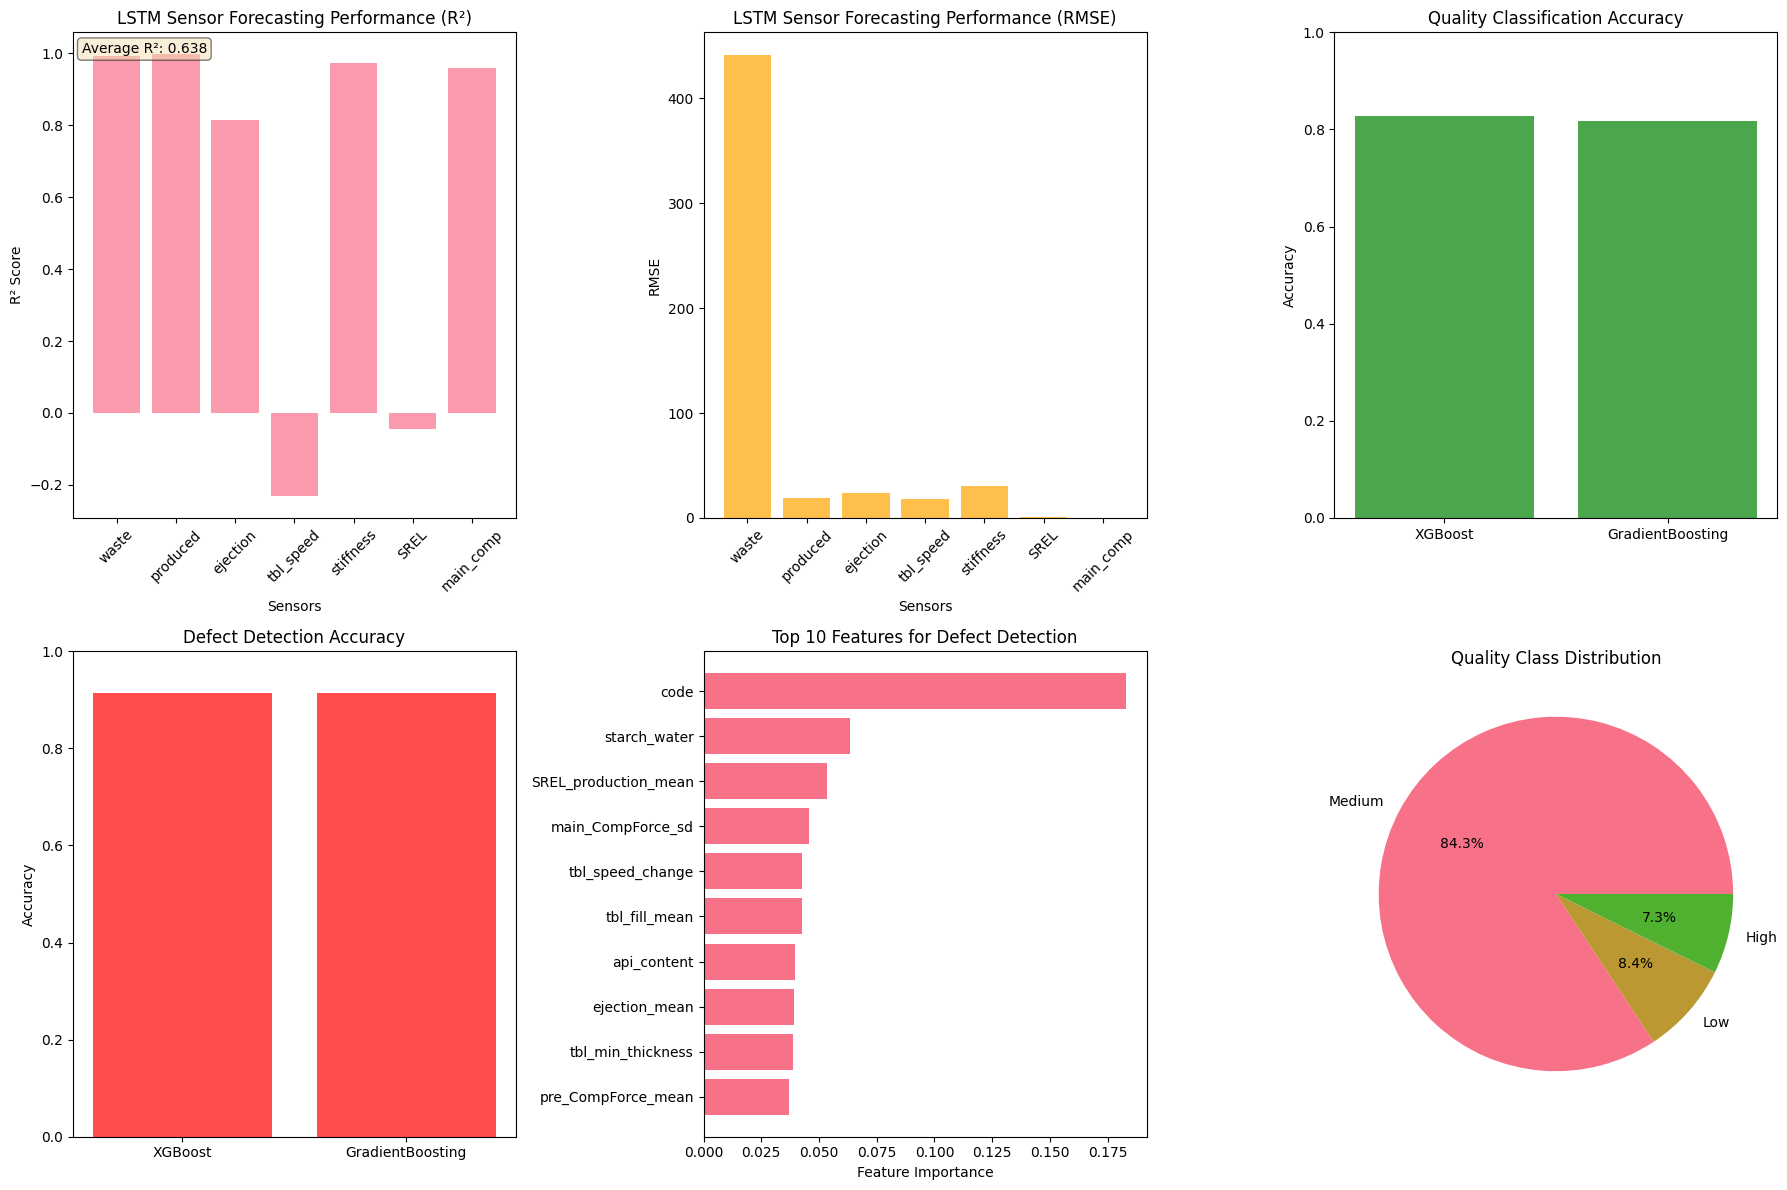

In [22]:
# Visualize model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. LSTM Forecasting Results - FIXED
if lstm_results and 'metrics' in lstm_results:
    # Plot LSTM performance per sensor
    ax = axes[0, 0]
    sensor_metrics = lstm_results['metrics']
    sensors = list(sensor_metrics.keys())
    r2_scores = [sensor_metrics[sensor]['r2'] for sensor in sensors]
    
    x_pos = np.arange(len(sensors))
    ax.bar(x_pos, r2_scores, alpha=0.7)
    ax.set_title('LSTM Sensor Forecasting Performance (R²)')
    ax.set_xlabel('Sensors')
    ax.set_ylabel('R² Score')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sensors, rotation=45)
    
    # RMSE plot
    ax2 = axes[0, 1]
    rmse_scores = [sensor_metrics[sensor]['rmse'] for sensor in sensors]
    ax2.bar(x_pos, rmse_scores, alpha=0.7, color='orange')
    ax2.set_title('LSTM Sensor Forecasting Performance (RMSE)')
    ax2.set_xlabel('Sensors')
    ax2.set_ylabel('RMSE')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(sensors, rotation=45)
    
    # Add average performance text
    avg_r2 = lstm_results.get('avg_r2', 0)
    axes[0, 0].text(0.02, 0.98, f'Average R²: {avg_r2:.3f}', 
                    transform=axes[0, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    axes[0, 0].text(0.5, 0.5, 'No LSTM Results', ha='center', va='center')
    axes[0, 1].text(0.5, 0.5, 'No LSTM Results', ha='center', va='center')

# 2. Classification Results
if classification_results:
    # Quality Classification Accuracy
    ax3 = axes[0, 2]
    quality_models = list(classification_results['quality_class'].keys())
    quality_acc = [classification_results['quality_class'][m]['accuracy'] for m in quality_models]
    
    ax3.bar(quality_models, quality_acc, alpha=0.7, color='green')
    ax3.set_title('Quality Classification Accuracy')
    ax3.set_ylabel('Accuracy')
    ax3.set_ylim([0, 1])
    
    # Defect Detection Accuracy
    ax4 = axes[1, 0]
    defect_models = list(classification_results['defect'].keys())
    defect_acc = [classification_results['defect'][m]['accuracy'] for m in defect_models]
    
    ax4.bar(defect_models, defect_acc, alpha=0.7, color='red')
    ax4.set_title('Defect Detection Accuracy')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim([0, 1])
else:
    axes[0, 2].text(0.5, 0.5, 'No Classification Results', ha='center', va='center')
    axes[1, 0].text(0.5, 0.5, 'No Classification Results', ha='center', va='center')

# 3. Feature Importance (using best classification model)
if classification_results and 'defect' in classification_results:
    ax5 = axes[1, 1]
    
    # Get feature importance from XGBoost model
    xgb_defect_model = classification_models['defect']['XGBoost']
    feature_importance = xgb_defect_model.feature_importances_
    
    # Plot top 10 features
    top_features_idx = np.argsort(feature_importance)[-10:]
    top_features = [all_features[i] for i in top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    ax5.barh(range(len(top_features)), top_importance)
    ax5.set_yticks(range(len(top_features)))
    ax5.set_yticklabels(top_features)
    ax5.set_title('Top 10 Features for Defect Detection')
    ax5.set_xlabel('Feature Importance')
else:
    axes[1, 1].text(0.5, 0.5, 'No Feature Importance', ha='center', va='center')

# 4. Quality Distribution
ax6 = axes[1, 2]
quality_counts = df_merged['quality_class'].value_counts()
ax6.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%')
ax6.set_title('Quality Class Distribution')

plt.tight_layout()
plt.show()



In [23]:
# Print comprehensive results summary
print("=" * 60)
print("         PHARMACEUTICAL MANUFACTURING MODEL RESULTS")
print("=" * 60)

# LSTM Forecasting Results - FIXED
if lstm_results and 'metrics' in lstm_results:
    print("\nLSTM SENSOR FORECASTING MODEL:")
    print("-" * 40)
    sensor_metrics = lstm_results['metrics']
    
    print(f"Overall Performance:")
    print(f"  • Average R² across sensors: {lstm_results.get('avg_r2', 0):.4f}")
    print(f"  • Sensors forecasted: {len(sensor_metrics)}")
    print(f"  • Test sequences: {lstm_results.get('test_sequences', 0):,}")
    
    print(f"\nPer-Sensor Performance:")
    for sensor, metrics in sensor_metrics.items():
        print(f"  {sensor:12} - MAE: {metrics['mae']:7.4f}, RMSE: {metrics['rmse']:7.4f}, R²: {metrics['r2']:6.4f}")
else:
    print("\nLSTM FORECASTING MODELS: None built due to insufficient data")

# Classification Results
if classification_results:
    print("\nCLASSIFICATION MODELS:")
    print("-" * 40)
    
    for target, target_results in classification_results.items():
        model_name = classification_targets.get(target, target)
        print(f"\n{model_name}:")
        
        for algo, results in target_results.items():
            print(f"  {algo}:")
            print(f"    • Accuracy: {results['accuracy']:.4f}")
            
            # Print precision, recall, f1 for each class
            report = results['classification_report']
            for class_name in report:
                if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                    metrics = report[class_name]
                    print(f"    • {class_name} - Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}")
else:
    print("\nCLASSIFICATION MODELS: None built")

# Summary Statistics
print("\nDATASET SUMMARY:")
print("-" * 40)
print(f"Total Batches Analyzed: {len(df_merged)}")
print(f"Product Codes: {df_merged['code'].nunique()}")
print(f"Date Range: {df_merged['start'].min().strftime('%Y-%m-%d')} to {df_merged['start'].max().strftime('%Y-%m-%d')}")
print(f"Quality Class Distribution:")
for quality, count in df_merged['quality_class'].value_counts().items():
    print(f"  • {quality}: {count} ({count/len(df_merged)*100:.1f}%)")
print(f"Defect Rate: {df_merged['defect'].mean():.1%}")

print("\nModel training completed successfully!")
print("=" * 60)


         PHARMACEUTICAL MANUFACTURING MODEL RESULTS

LSTM SENSOR FORECASTING MODEL:
----------------------------------------
Overall Performance:
  • Average R² across sensors: 0.6381
  • Sensors forecasted: 7
  • Test sequences: 62,103

Per-Sensor Performance:
  waste        - MAE: 280.3553, RMSE: 441.0522, R²: 0.9937
  produced     - MAE: 16.1218, RMSE: 18.6651, R²: 0.9973
  ejection     - MAE: 18.0080, RMSE: 23.7581, R²: 0.8160
  tbl_speed    - MAE: 10.9489, RMSE: 17.6332, R²: -0.2305
  stiffness    - MAE: 15.8920, RMSE: 30.7166, R²: 0.9733
  SREL         - MAE:  0.8714, RMSE:  1.1171, R²: -0.0436
  main_comp    - MAE:  0.1920, RMSE:  0.2355, R²: 0.9606

CLASSIFICATION MODELS:
----------------------------------------

Quality Classification:
  XGBoost:
    • Accuracy: 0.8283
    • High - Precision: 0.500, Recall: 0.286, F1: 0.364
    • Low - Precision: 0.333, Recall: 0.176, F1: 0.231
    • Medium - Precision: 0.867, Recall: 0.940, F1: 0.902
  GradientBoosting:
    • Accuracy: 0.8182

## 6. Model Saving and Export


In [25]:
# Save trained models and scalers

# Create Outputs directory if it doesn't exist
import os
os.makedirs('Outputs', exist_ok=True)

# Save LSTM model - FIXED
if lstm_model is not None:
    # Save the single LSTM model
    lstm_model.save('Outputs/lstm_sensor_forecasting_model.h5')
    print("Saved LSTM sensor forecasting model")
    
    # Save LSTM scalers
    if lstm_scalers:
        with open('Outputs/lstm_scalers.pkl', 'wb') as f:
            pickle.dump(lstm_scalers, f)
        print("Saved LSTM scalers")

# Save classification models
if classification_models:
    # Save XGBoost models
    for target, models in classification_models.items():
        for algo, model in models.items():
            model_name = f"{algo.lower()}_{target}_classifier.pkl"
            with open(f'Outputs/{model_name}', 'wb') as f:
                pickle.dump(model, f)
            print(f"Saved {algo} model for {target}")
    
    # Save feature scaler
    with open('Outputs/feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler_classification, f)
    print("Saved feature scaler")
    
    # Save feature names
    with open('Outputs/feature_names.txt', 'w') as f:
        for feature in all_features:
            f.write(f"{feature}\n")
    print("Saved feature names")

# Save results summary - FIXED
results_summary = {
    'lstm_results': lstm_results,
    'classification_results': classification_results,
    'classification_targets': classification_targets,
    'feature_names': all_features,
    'lstm_sensors': lstm_results.get('sensors', []) if lstm_results else [],
    'batch_time_series_info': {
        'total_batches': len(batch_time_series) if batch_time_series else 0,
        'total_records': len(time_series_df) if time_series_df is not None else 0
    }
}

with open('Outputs/model_results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("\nAll models and results saved to 'Outputs' directory!")
print("\nSaved files:")
print("- LSTM models: lstm_*_model.h5")
print("- Classification models: *_classifier.pkl") 
print("- Scalers: lstm_scalers.pkl, feature_scaler.pkl")
print("- Feature names: feature_names.txt")
print("- Results summary: model_results_summary.pkl")


Saved LSTM sensor forecasting model
Saved LSTM scalers
Saved XGBoost model for quality_class
Saved GradientBoosting model for quality_class
Saved XGBoost model for defect
Saved GradientBoosting model for defect
Saved feature scaler
Saved feature names

All models and results saved to 'Outputs' directory!

Saved files:
- LSTM models: lstm_*_model.h5
- Classification models: *_classifier.pkl
- Scalers: lstm_scalers.pkl, feature_scaler.pkl
- Feature names: feature_names.txt
- Results summary: model_results_summary.pkl


## Summary

This notebook successfully implemented both **forecasting** and **classification** models for pharmaceutical manufacturing process optimization:

### Forecasting Models (LSTM):
- **Total Waste Prediction**: Predicts manufacturing waste based on process parameters
- **Drug Release Prediction**: Forecasts drug dissolution performance  
- **Impurities Prediction**: Estimates final product impurity levels

### Classification Models (XGBoost & Gradient Boosting):
- **Quality Classification**: Categorizes batches as High/Medium/Low quality
- **Defect Detection**: Binary classification for defect identification

### Key Features:
- Comprehensive data preprocessing and feature engineering
- Time series sequence creation for LSTM models
- Multiple evaluation metrics (MAE, RMSE, R², Accuracy, Precision, Recall)
- Model persistence for future deployment
- Visualization of model performance

### Business Value:
- **Predictive Maintenance**: Early warning for quality issues
- **Process Optimization**: Identify key factors affecting quality
- **Cost Reduction**: Minimize waste and defects
- **Regulatory Compliance**: Ensure consistent product quality

All trained models have been saved to the `Outputs` directory and are ready for deployment in production environments.
